## Dataset
### Retrieving the dataset
In this part of the notebook, the dataset provided is transferred from the dataset files (h5).

In [1]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

class Dataset:
    def __init__(self, train_dataset_path, test_dataset_path):
        ## Training dataset
        self.train_data = h5py.File(train_dataset_path, 'r') # Change with directory of training dataset
        ## Testing dataset
        self.test_data = h5py.File(test_dataset_path, 'r') # Change with directory of testing dataset

    def get_training_data(self):
        ## Organizing training dataset
        train_set = {
            'samples': np.array(self.train_data['train_set_x']) / 255,
            'labels': np.array(self.train_data['train_set_y'], dtype = np.int16)
        }
        return train_set

    def get_testing_data(self):
        ## Organizing testing dataset
        test_set = {
            'samples': np.array(self.test_data['test_set_x']) / 255,
            'labels': np.array(self.test_data['test_set_y'], dtype = np.int16)
        }
        return test_set

### Structure of Dataset
Dataset is orgaized as a class(Dataset class) that has attributes train_data and test_data containing the necessary data. Training data can be accessed by using *get_training_data method* and testing dataset can be accessed by using *get_testing_data* method. The returned values are dictionaries that contains dataset samples (under dictionary entry 'samples') and according labels (under dictionary entry 'labels'). For constructing the dataset, use the Dataset class contructor with path of training dataset and path of testing dataset. The dataset files are assumed to be h5 files. Sample constructor **Dataset(train_data_path, test_data_path)**

In [2]:
# For proper execution change the paths of training and testing dataset, as this notebook is running on Google Colab, corresponding paths are used.
train_dataset_path = 'train_catvnoncat.h5'
test_dataset_path = 'test_catvnoncat.h5'
dataset = Dataset(train_dataset_path, test_dataset_path)

## Part 1
### Logistic Regression classifier
For clarity, the functionality requested for this question is given in a class named **LogisticClassifier**. Objects of this class is able to perform the classification by both approaches requested. The implementation following the iterative approach is provided with the method **iterative_training** and matrix operation approach is provided with the method **matrix_training**. In training, in order to avoid division by 0 and exponential overflow a small number like $e^{-30}$ is used. This sets a threshold to the minimum possible weight.

In [3]:
class LogisticClassifier:
    def __init__(self, training_dataset_path, testing_dataset_path, learning_rate, init_pref):
        self.dataset = Dataset(training_dataset_path, testing_dataset_path)
        train_data = self.dataset.get_training_data()
        test_data = self.dataset.get_testing_data()
        self.train_sample_count = train_data['samples'].shape[0]
        self.test_sample_count = test_data['samples'].shape[0]
        self.data_shape = (train_data['samples'].shape[1], train_data['samples'].shape[2], train_data['samples'].shape[3])
        self.train_samples = np.reshape(train_data['samples'], (self.train_sample_count, self.data_shape[0] * self.data_shape[1] * self.data_shape[2])).T
        self.train_labels = train_data['labels']
        self.test_samples = np.reshape(test_data['samples'], (self.test_sample_count, self.data_shape[0] * self.data_shape[1] * self.data_shape[2])).T
        self.test_labels = test_data['labels']
        # The number of weights is determined by (number of rows) x (number of columns) x (number of channels)
        # There are 3 alternatives for weights initilization 
        # uniform nonzero distribution, normal distribution or 0's
        try:
            if init_pref == 'normal':
                self.weights = np.array(np.random.normal(loc = 0, scale = 0.01, size = (self.data_shape[0] * self.data_shape[1] * self.data_shape[2],1)))
                self.init_pref = 'normal'
            elif init_pref == 'uniform':
                self.weights = np.array(np.random.uniform(low = 0, high = 0.01, size = (self.data_shape[0] * self.data_shape[1] * self.data_shape[2],1)))
                self.init_pref = 'uniform'
            elif init_pref == 'zeros':
                self.weights = np.zeros((self.data_shape[0] * self.data_shape[1] * self.data_shape[2], 1))
                self.init_pref = 'zeros'
            else:
                raise ValueError('Invalid value for init_pref, enter one of (normal, uniform, zeros)')
        except ValueError as err:
            print(err)
        self.bias = 0 # Bias is initialized as 0
        self.learning_rate = learning_rate

    def iterative_training(self):
        # Initialize the loss and weight derivatives and bias derivative
        total_loss = 0
        weight_derivatives = np.zeros((self.data_shape[0] * self.data_shape[1] * self.data_shape[2], 1))
        bias_derivative = 0
        # Traversing through samples
        for sample_idx in range(self.train_sample_count):
            z = np.dot(self.weights.T, self.train_samples[:,sample_idx]) + self.bias
            a = (1 / (1 + np.exp(-z))).item()
            total_loss += (-self.train_labels[sample_idx] * np.log(a + np.exp(-30)) - (1 - self.train_labels[sample_idx]) * np.log(1 - a + np.exp(-30)))
            dz = a - self.train_labels[sample_idx]
            weight_derivatives += dz * np.reshape(self.train_samples[:, sample_idx], (self.train_samples[:, sample_idx].size, 1))
        total_loss = total_loss / self.train_sample_count
        weight_derivatives = weight_derivatives / self.train_sample_count
        bias_derivative = bias_derivative / self.train_sample_count
        self.weights = self.weights - (self.learning_rate * weight_derivatives)
        self.bias = self.bias - (self.learning_rate * bias_derivative)
        return total_loss


    def matrix_training(self):
        z = np.dot(self.weights.T, self.train_samples) + self.bias
        a = 1 / (1 + np.exp(-z))
        dz = a - np.reshape(self.train_labels, (1, self.train_sample_count))
        dw = (1 / self.train_sample_count) * np.dot(self.train_samples, dz.T)
        db = (1 / self.train_sample_count) * np.sum(dz)
        self.weights = self.weights - (self.learning_rate * dw)
        self.bias = self.bias - (self.learning_rate * db)
        reshaped_labels = np.reshape(self.train_labels, (1, self.train_sample_count))
        return np.sum(-reshaped_labels * np.log(a + np.exp(-30)) - (1 - reshaped_labels) * np.log(1 - a + np.exp(-30))) / self.train_sample_count
        

    
    def train_and_test(self, epoch):
        # For efficiency purposes, the matrix approach has been followed for training
        train_loss_values = np.zeros(epoch)
        test_loss_values = np.zeros(epoch)
        test_acc_values = np.zeros(epoch)
        for epoch_no in range(epoch):
            train_loss_values[epoch_no] = self.matrix_training()
            test_data = self.test()
            test_loss_values[epoch_no] = test_data[0]
            test_acc_values[epoch_no] = test_data[1]
        return (train_loss_values, test_loss_values, test_acc_values)

    def test(self):
        correct_labels = 0
        total_loss = 0
        for sample_idx in range(self.test_sample_count):
            z = np.dot(self.weights.T, self.test_samples[:, sample_idx]) + self.bias
            a = (1 / (1 + np.exp(-1 * z))).item()
            total_loss += (-self.test_labels[sample_idx] * np.log(a + np.exp(-30)) - (1 - self.test_labels[sample_idx]) * np.log(1 - a + np.exp(-30)))
            if a < 0.5 and self.test_labels[sample_idx] == 0:
                correct_labels += 1
            elif a >= 0.5 and self.test_labels[sample_idx] == 1:
                correct_labels += 1
        return (total_loss / self.test_sample_count, correct_labels / self.test_sample_count)
    def classifier_main(self, epoch):
        model_data = self.train_and_test(epoch)
        train_loss = model_data[0]
        test_loss = model_data[1]
        test_acc = model_data[2]
        fig, (axis_1, axis_2) = plt.subplots(1,2, figsize = (16,5))
        title = 'Plots for learning rate = ' + str(self.learning_rate) + ' and epoch = ' + str(epoch) + ', init pref = ' + str(self.init_pref)
        fig.suptitle(title, fontsize = 18)
        axis_1.plot(range(1, epoch + 1), train_loss, color = 'blue')
        axis_1.plot(range(1, epoch + 1), test_loss, color = 'magenta')
        axis_1.legend(['Training loss', 'Testing loss'])
        axis_1.set(xlabel = 'Epoch', ylabel = 'Loss')
        axis_1.set_title('Training and Testing losses vs Epoch count')
        axis_2.plot(range(1, epoch + 1), test_acc, color = 'green')
        axis_2.set_title('Accuracy vs Epoch count')
        axis_2.set(xlabel = 'Epoch', ylabel = 'Accuracy')
        plt.show()
        plt.close()

### Testing for learning rate = 0.0001 and 50 epochs
For the purpose of this part, the Logistic Regression Classifier will be trained with the configuration learning rate = 0.0001 and epoch count = 50. Here for initialization of weights, three different alteranitves have been tried, which are starting the weights according to an uniform dist. with nonzero values, zeros and a normal distribution with mean = 0 and std. dev = 0.1.

In [4]:
def evaluate(training_dataset_path, testing_dataset_path, learning_rate, epoch_count, init_pref):
    classifier = LogisticClassifier(training_dataset_path, testing_dataset_path, learning_rate, init_pref)
    classifier.classifier_main(epoch_count)
def main_part1(train_dataset_path, test_dataset_path):
    evaluate(train_dataset_path, test_dataset_path, 0.001, 50, 'zeros')
    evaluate(train_dataset_path, test_dataset_path, 0.001, 50, 'uniform')
    evaluate(train_dataset_path, test_dataset_path, 0.001, 50, 'normal')

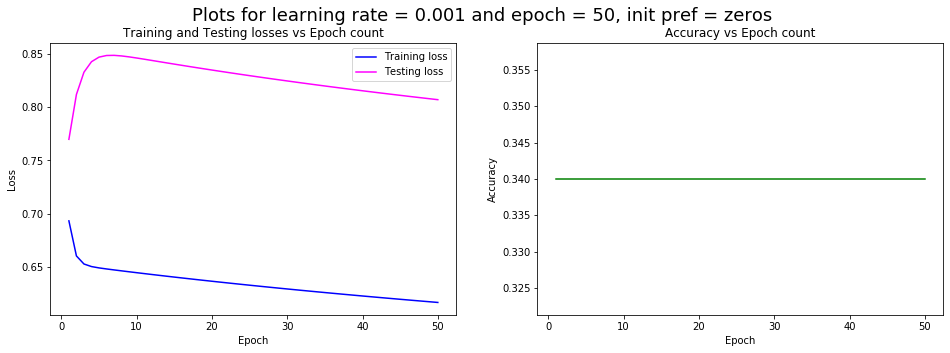

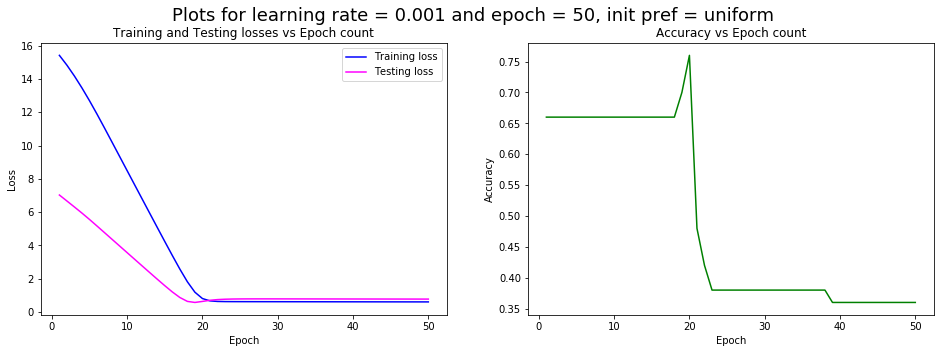

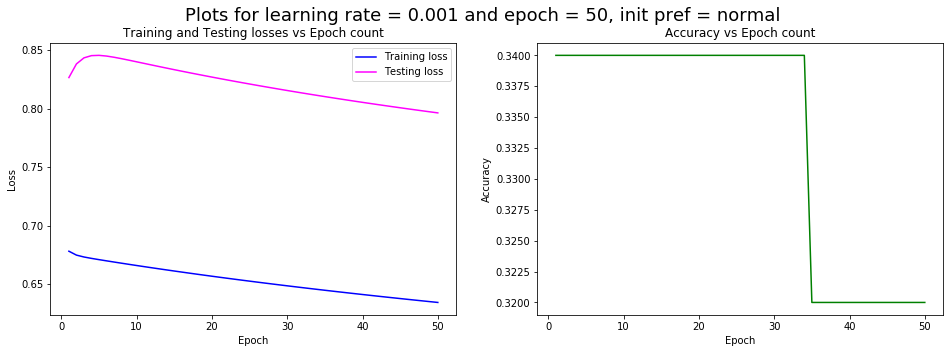

In [5]:
main_part1(train_dataset_path, test_dataset_path)

## Part 2
#### Cost vs Epoch
In this part of the assignment, the best hyperparameters will be searched for the classification task. In a grid search manner, the hyper parameters that are tried will be attempted and just as the parts above, the accuracy and loss results will be outputted for each possible configuration.

In [6]:
def prepare_parameter_grid():
    epochs = [50, 500, 1000, 2500]
    learning_rates = [0.0001, 0.001, 0.003, 0.01, 1]
    grid = []
    for epoch in epochs:
        for rate in learning_rates:
            grid.append((epoch, rate, 'uniform'))
            grid.append((epoch, rate, 'normal'))
            grid.append((epoch, rate, 'zeros'))
    return grid
def main_part2():
    param_grid = prepare_parameter_grid()
    for param in param_grid:
        evaluate(train_dataset_path, test_dataset_path, param[1], param[0], param[2])

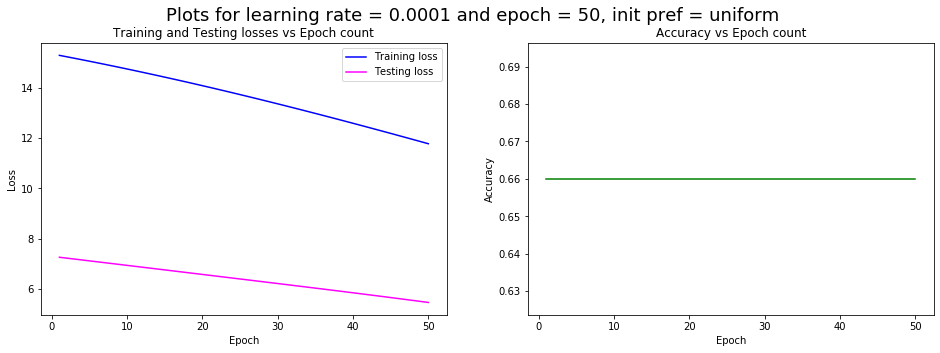

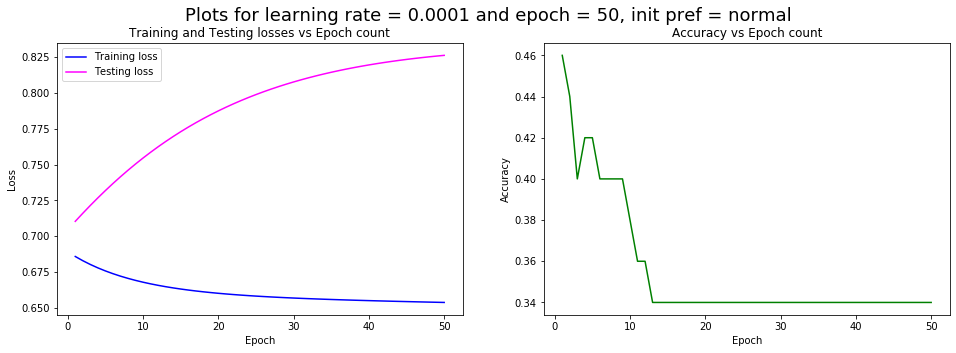

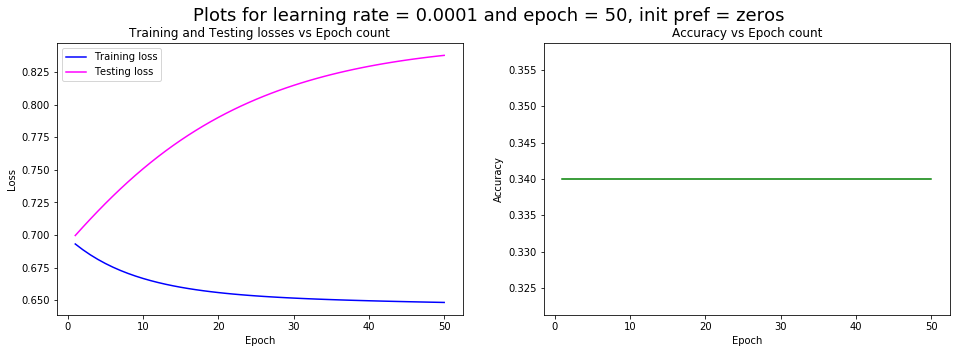

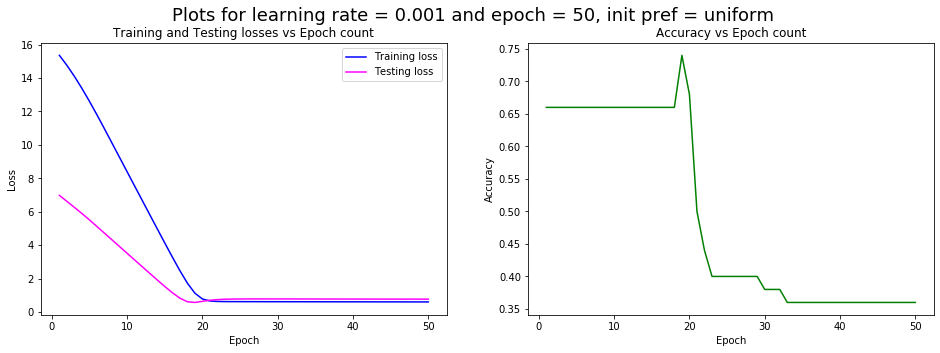

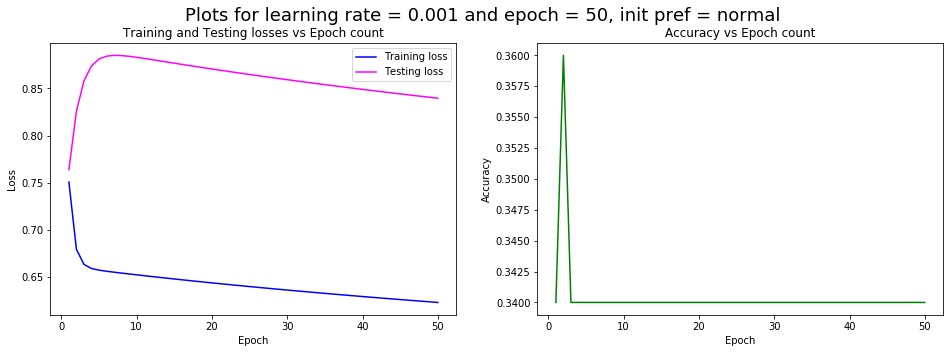

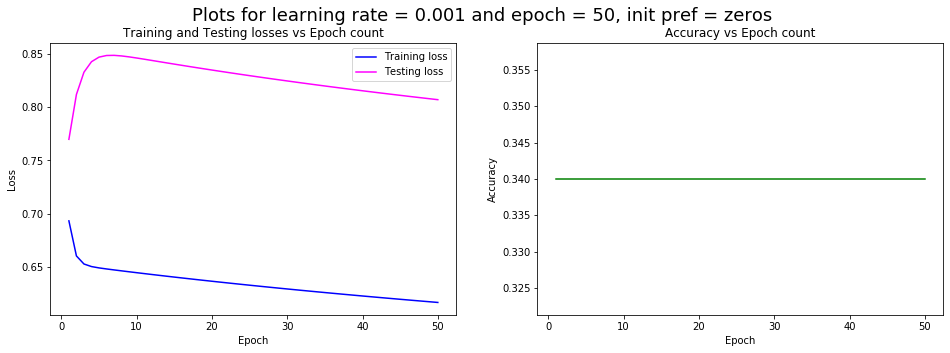

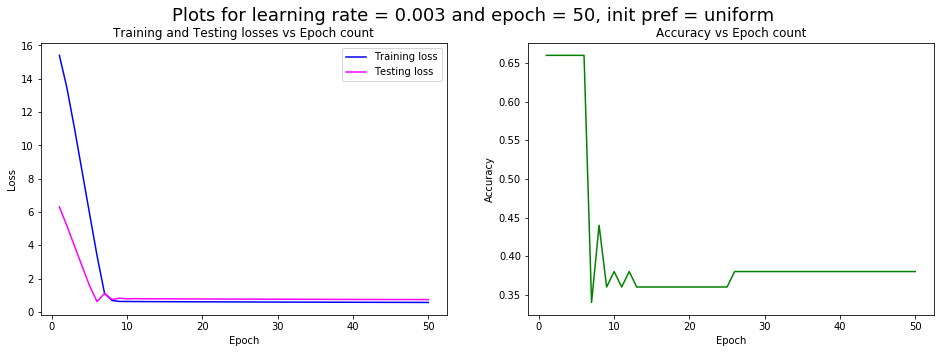

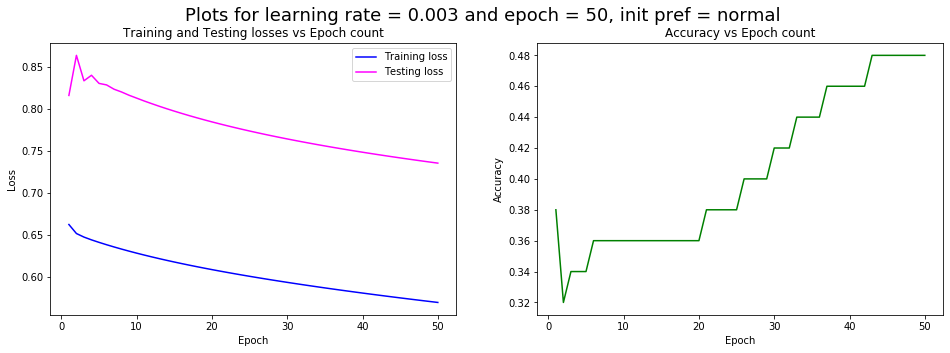

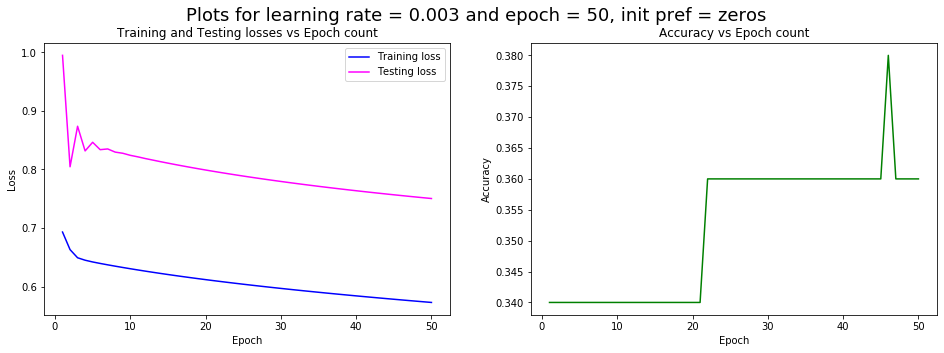

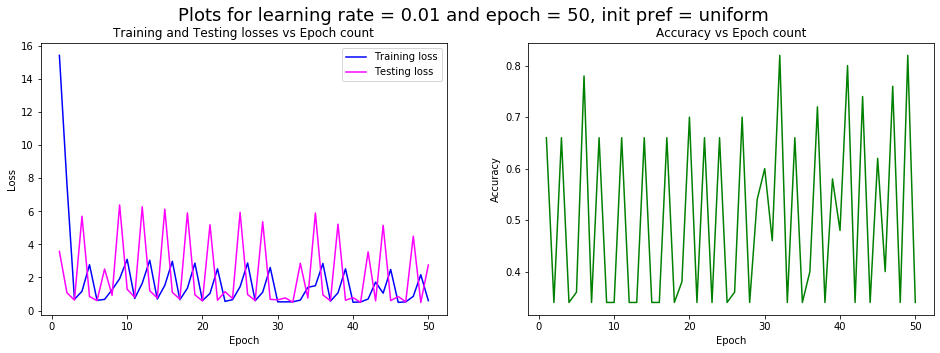

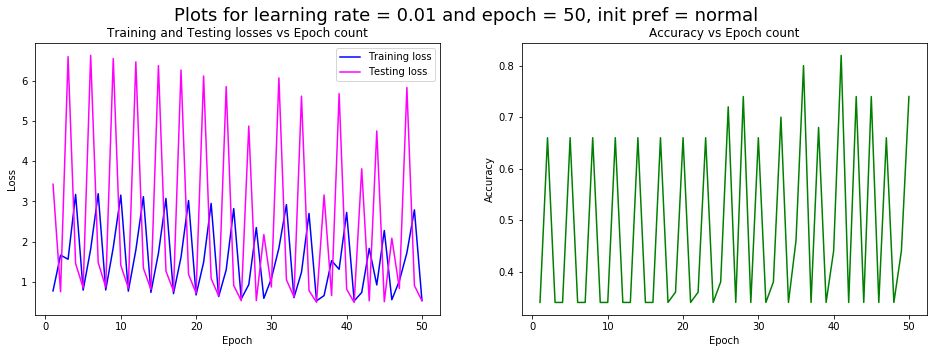

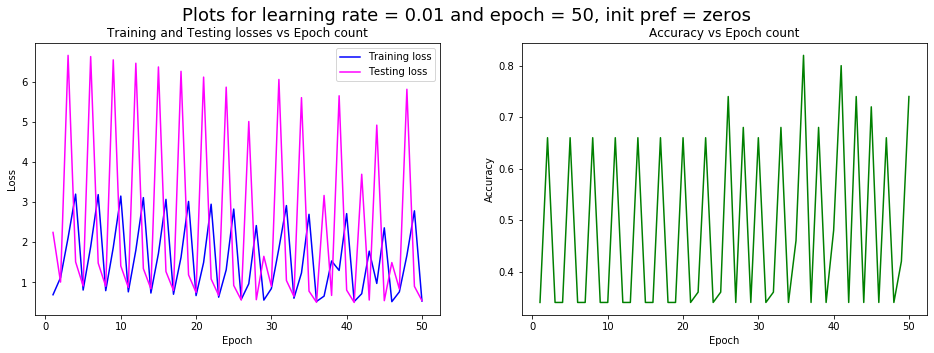

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: overflow encountered in exp
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in exp


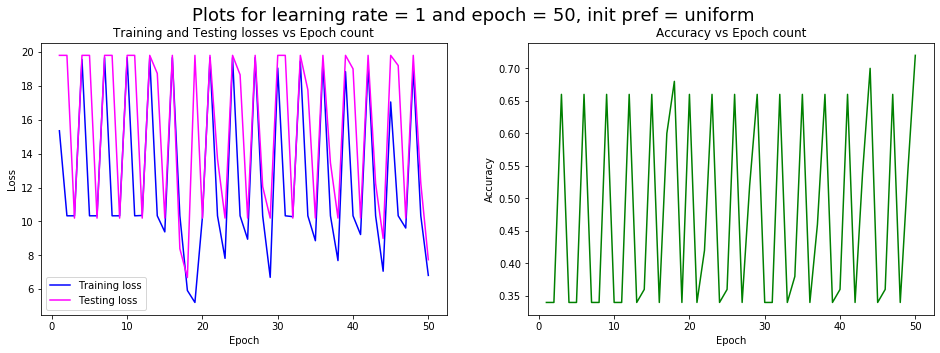

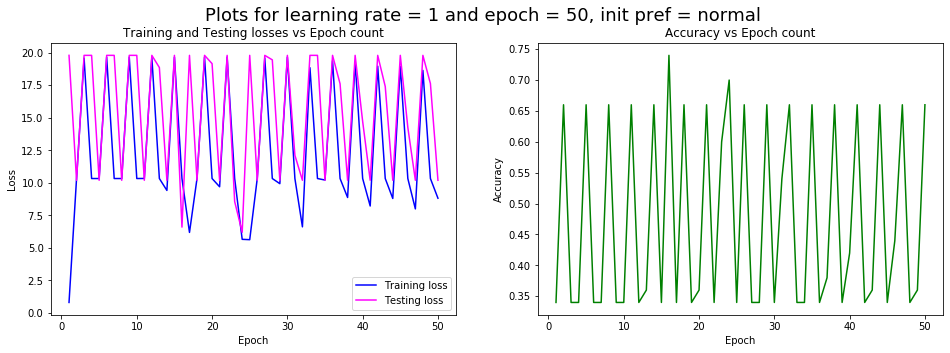

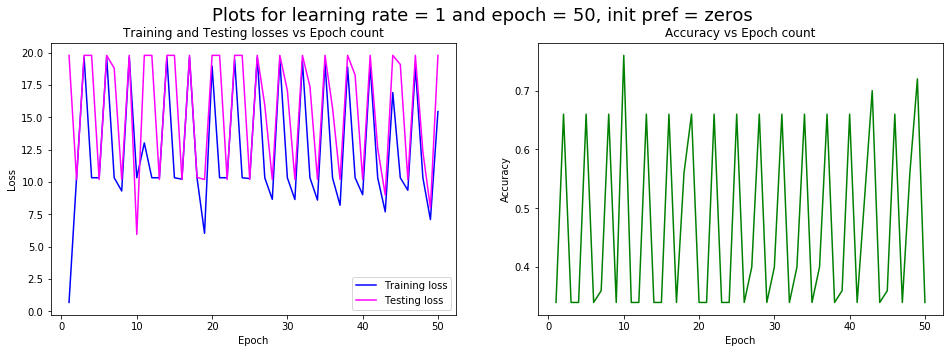

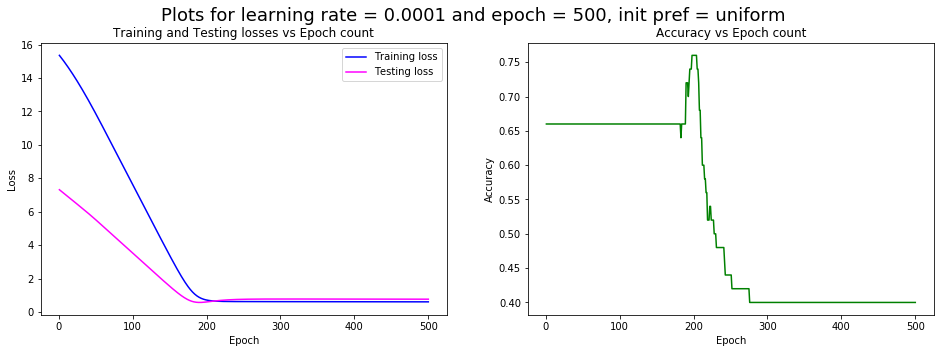

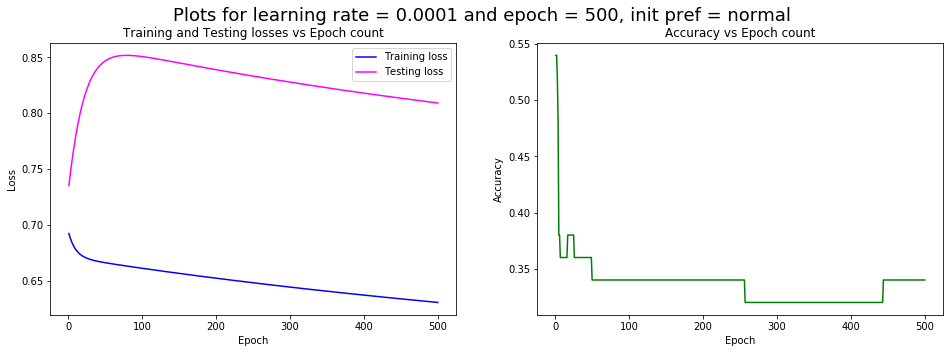

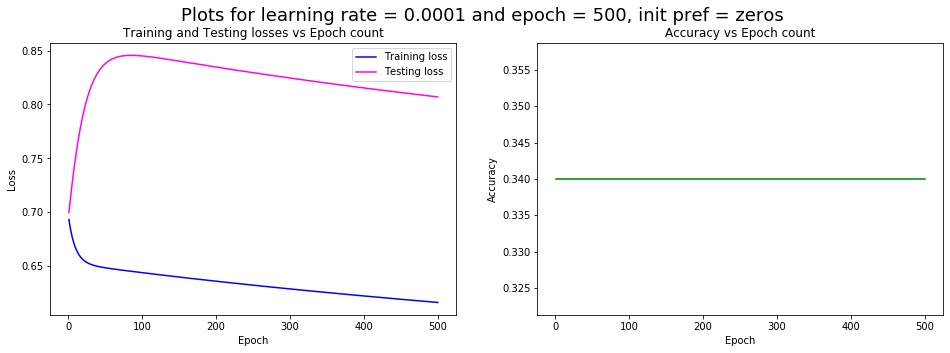

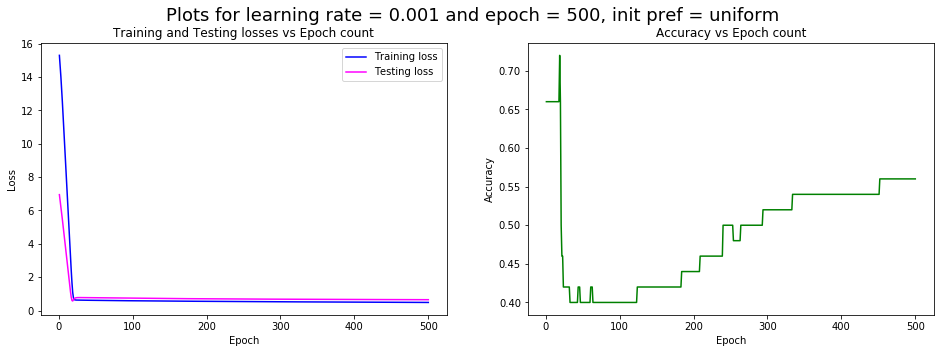

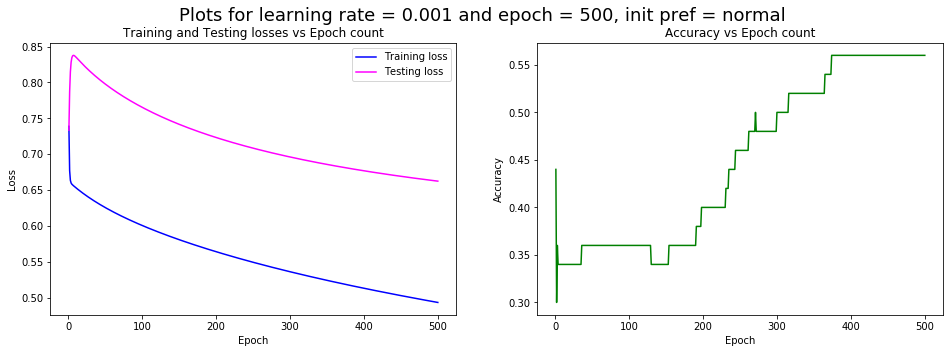

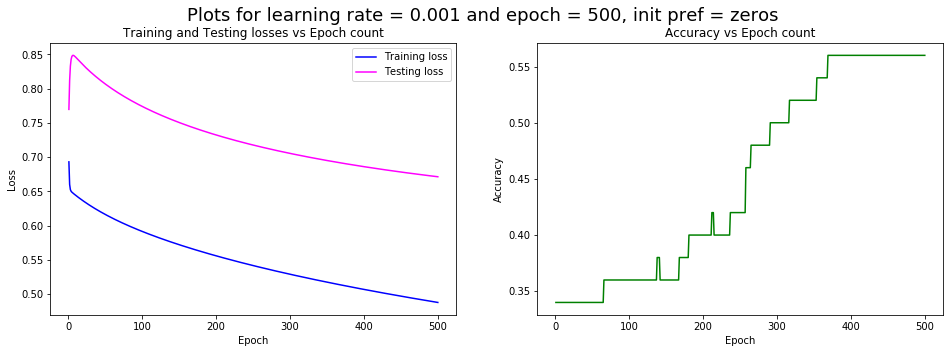

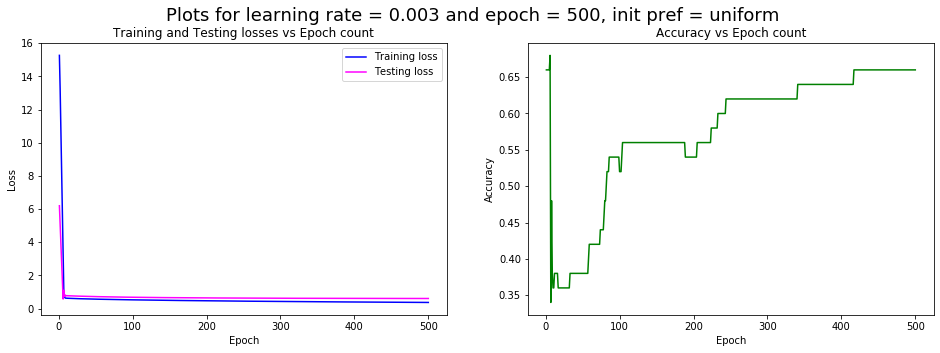

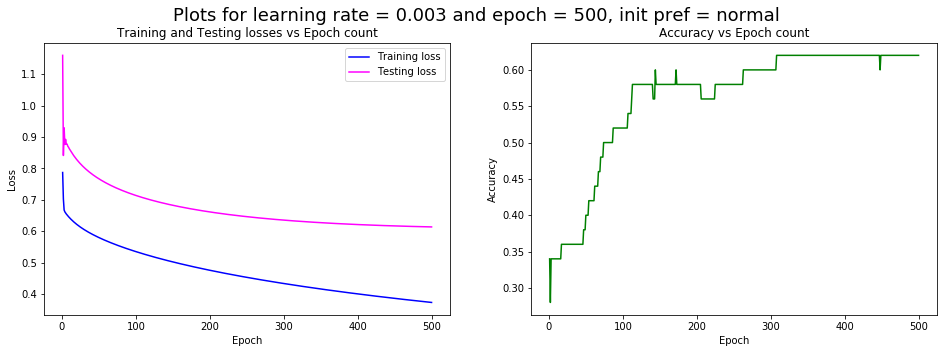

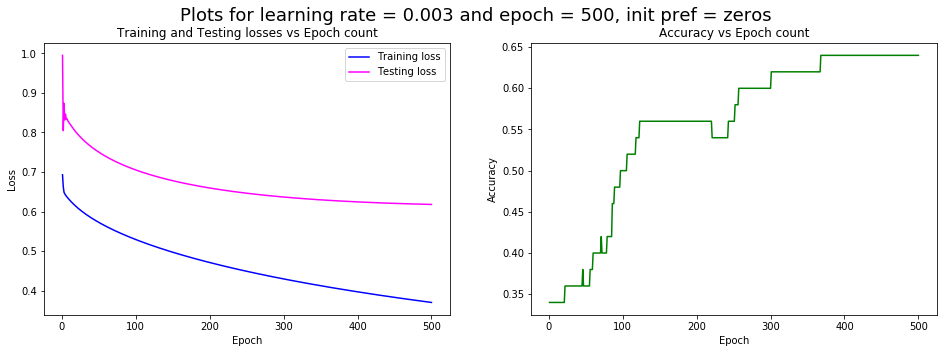

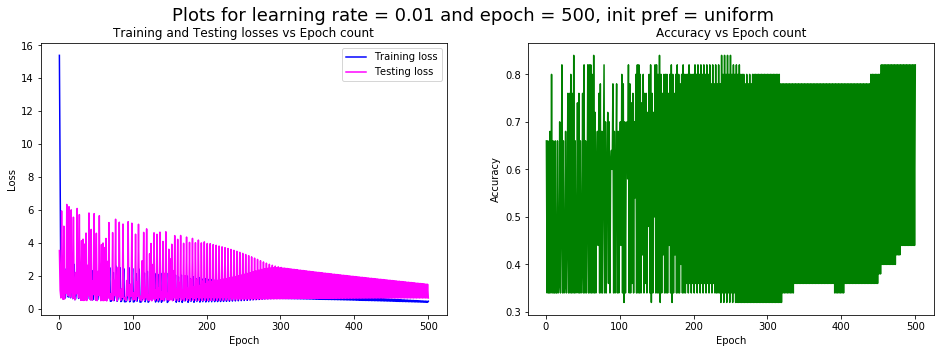

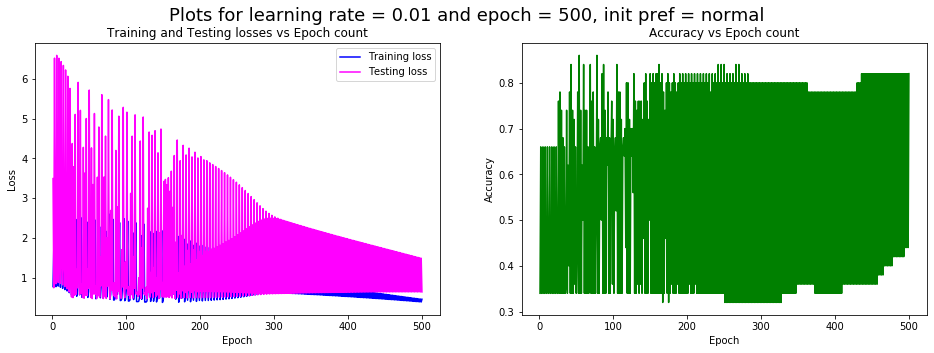

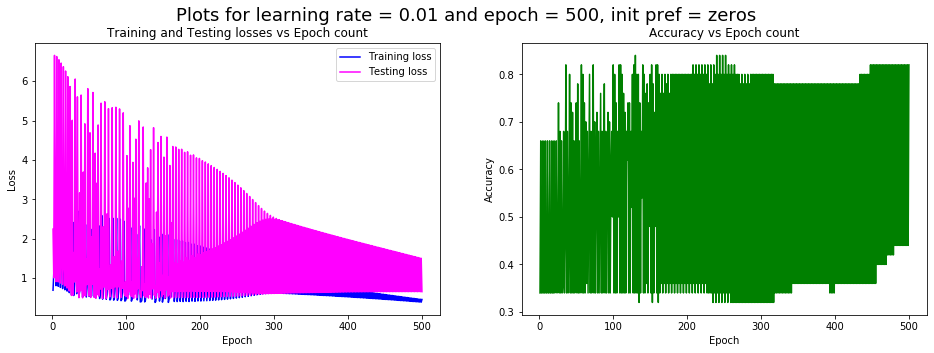

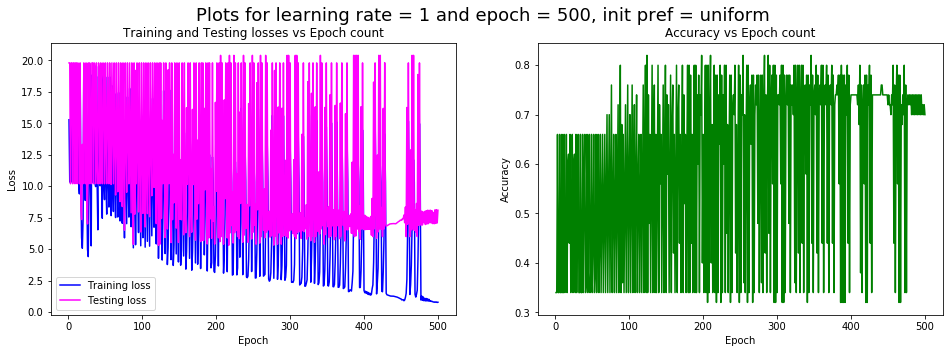

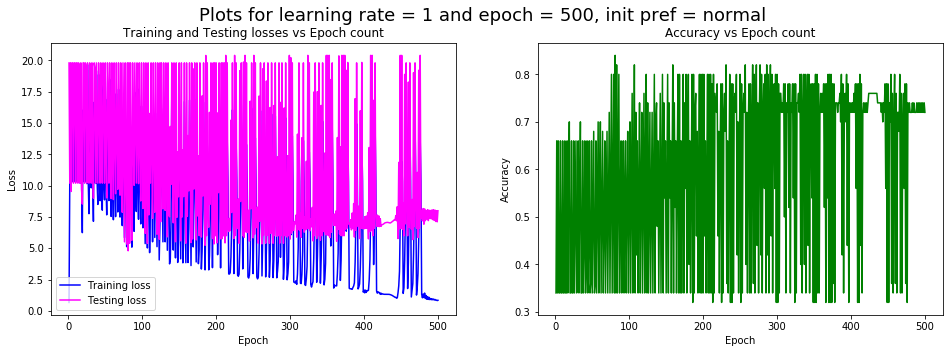

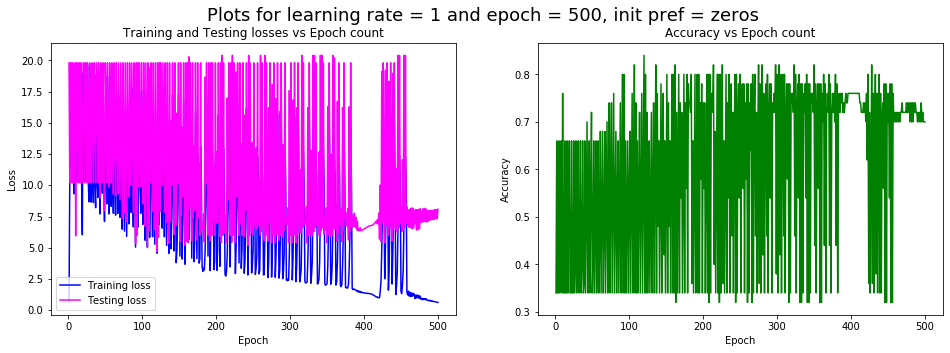

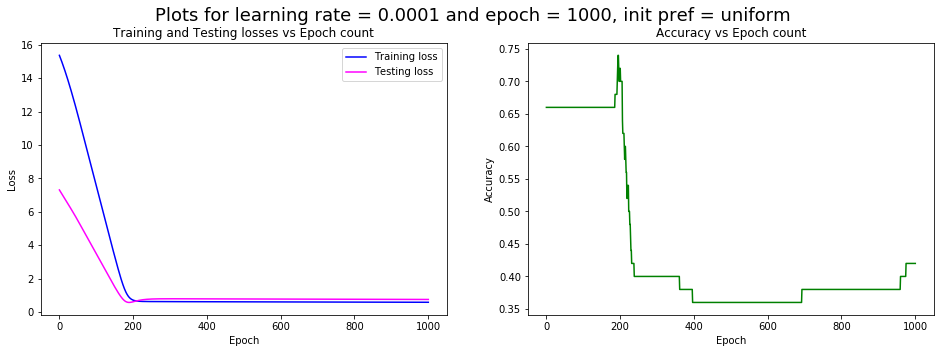

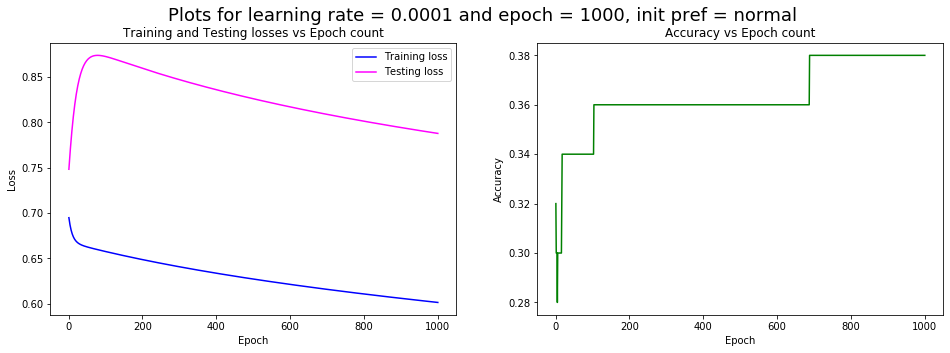

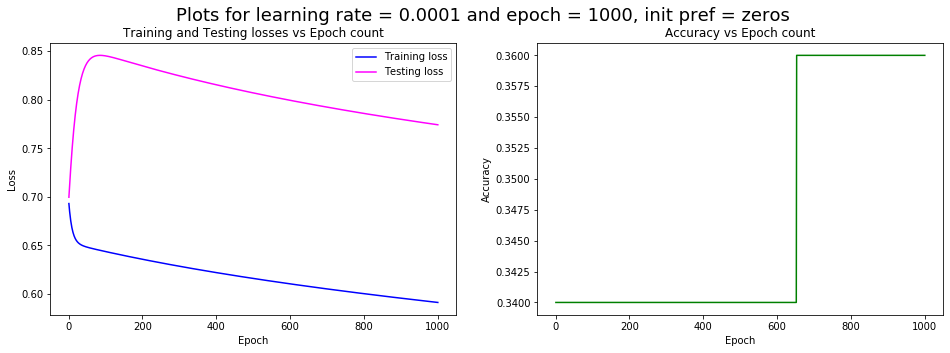

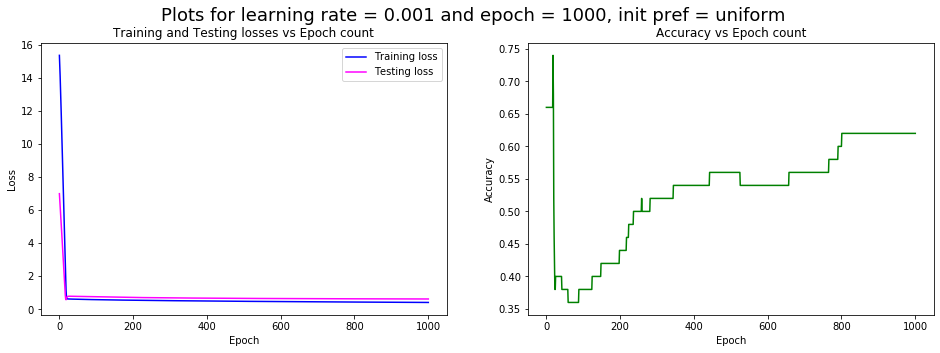

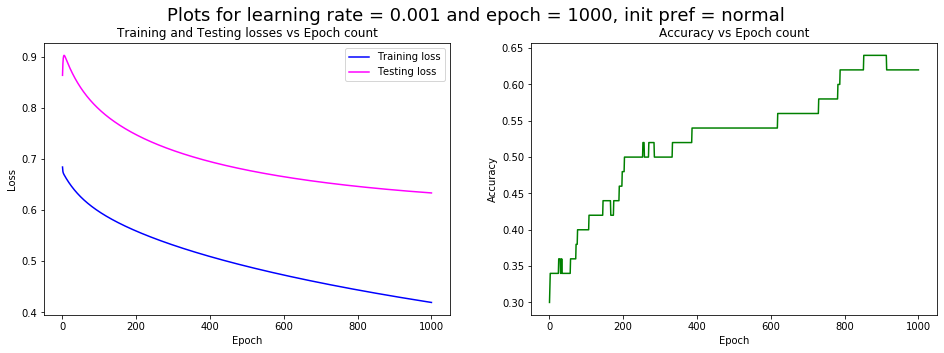

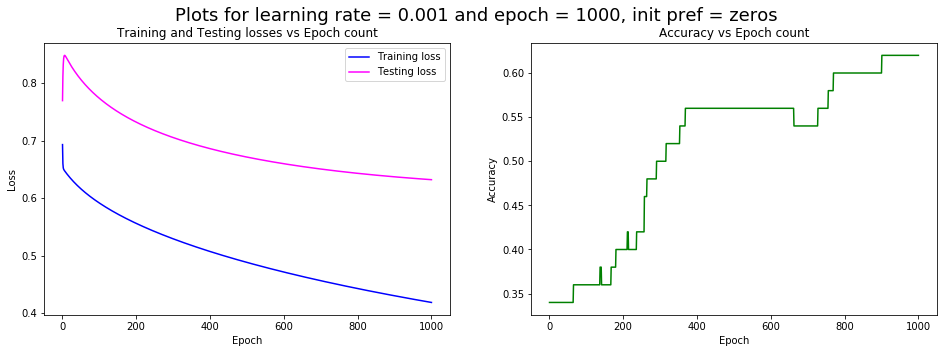

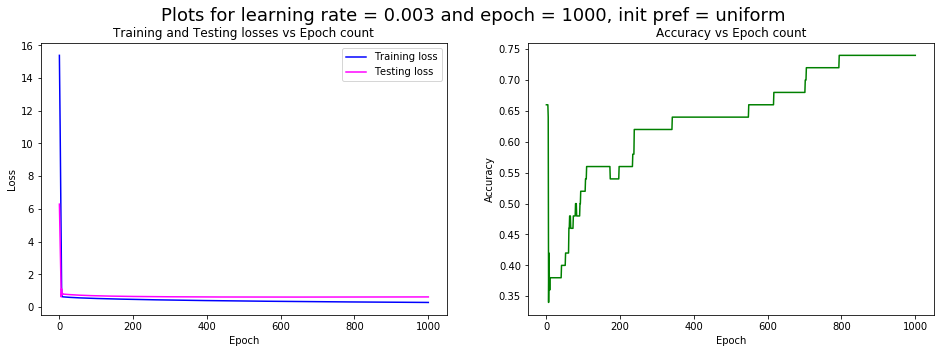

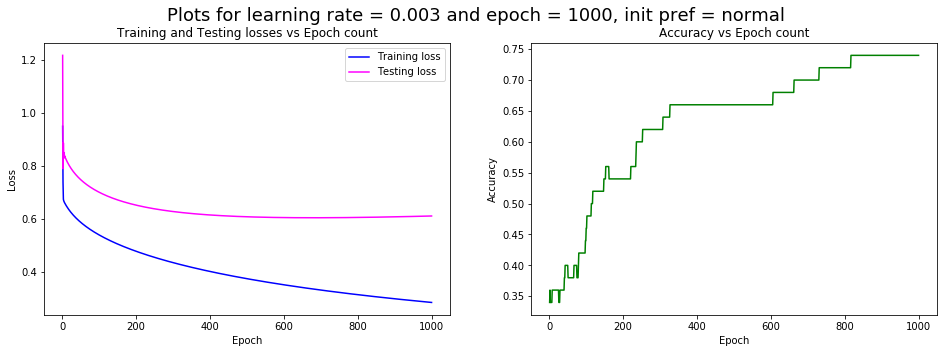

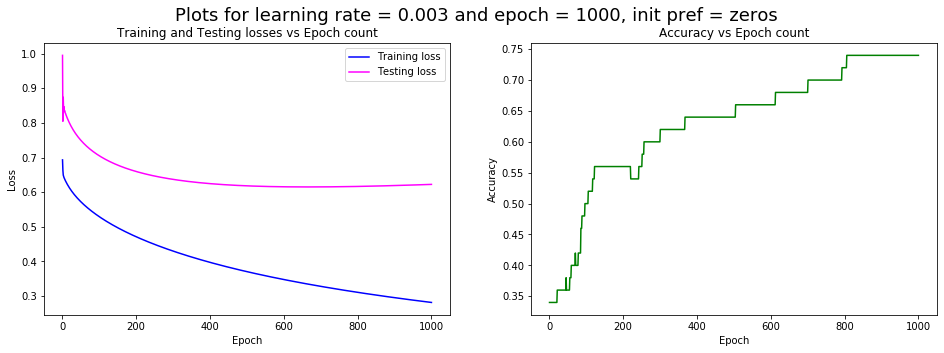

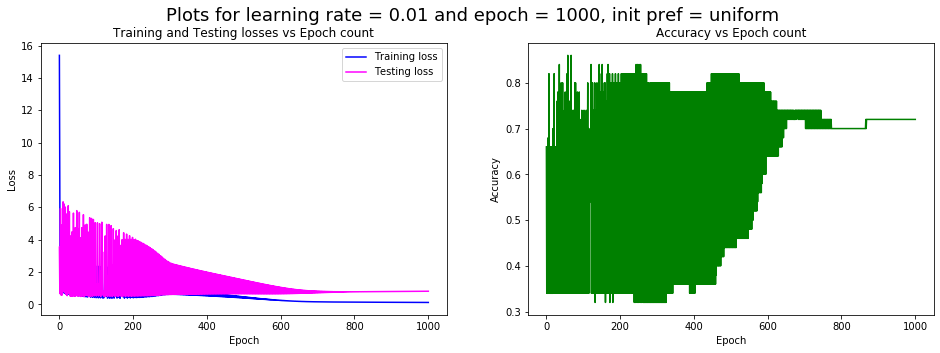

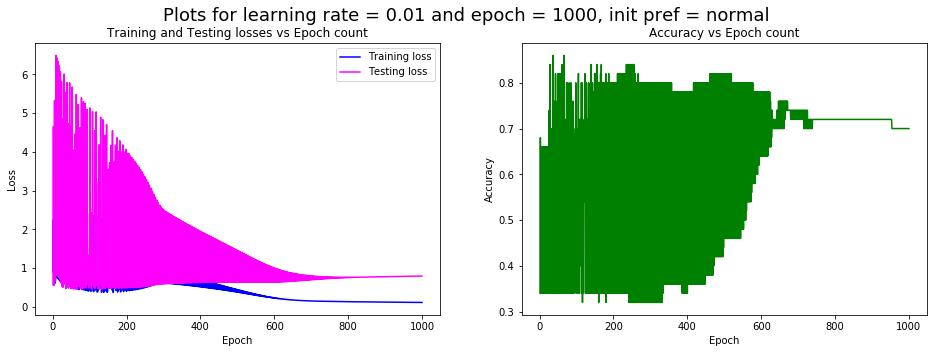

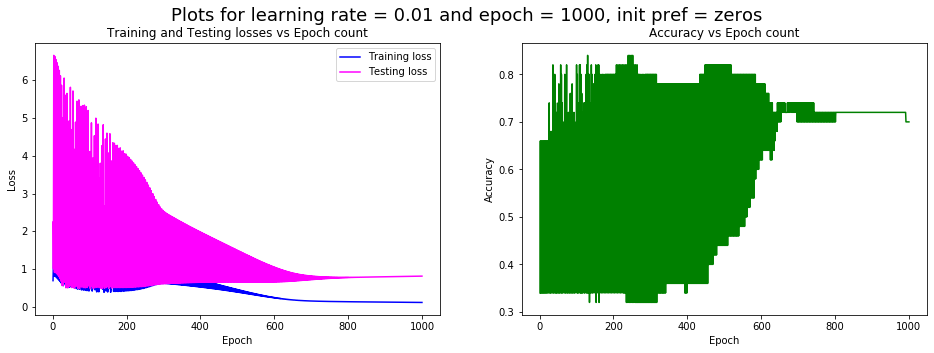

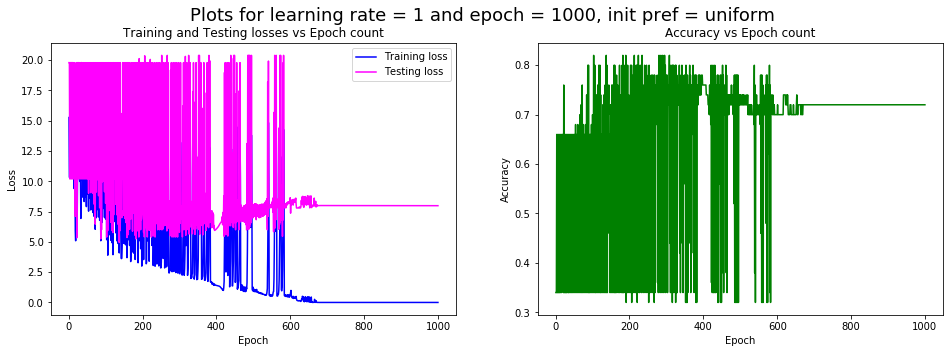

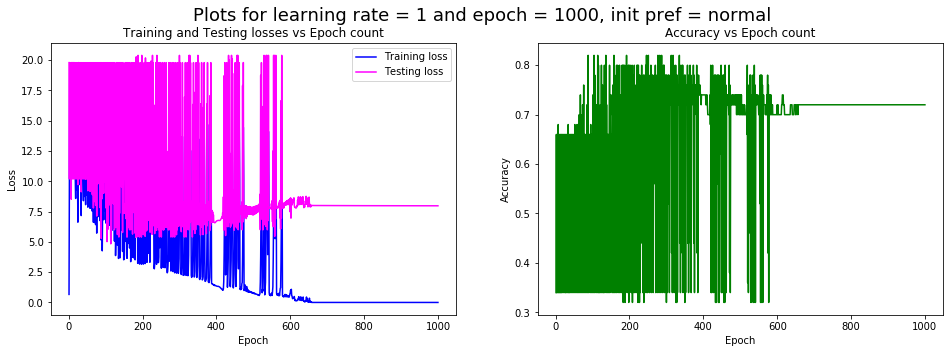

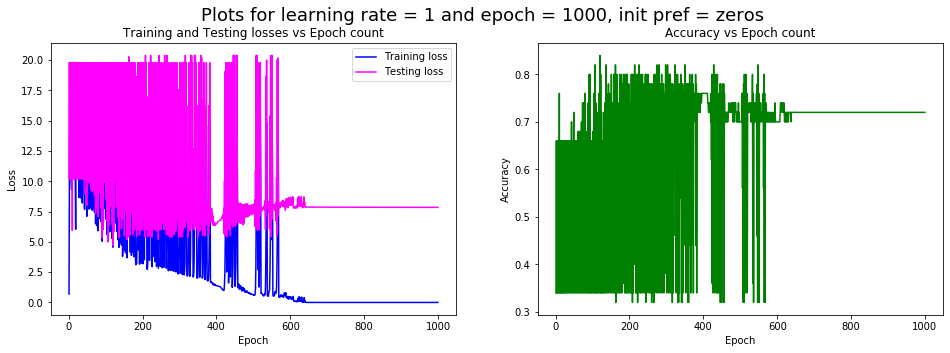

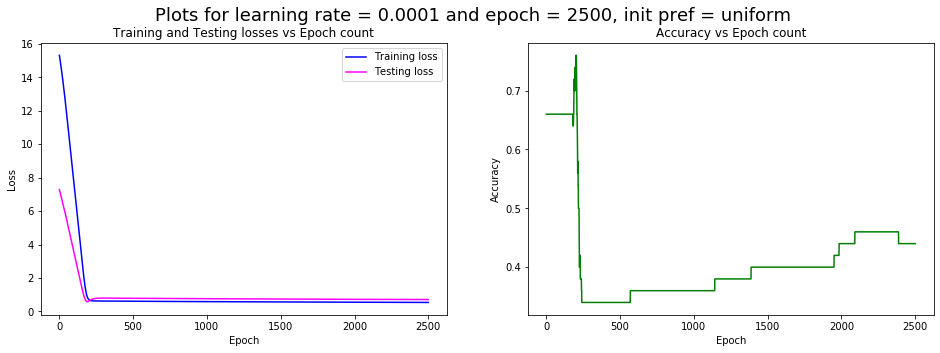

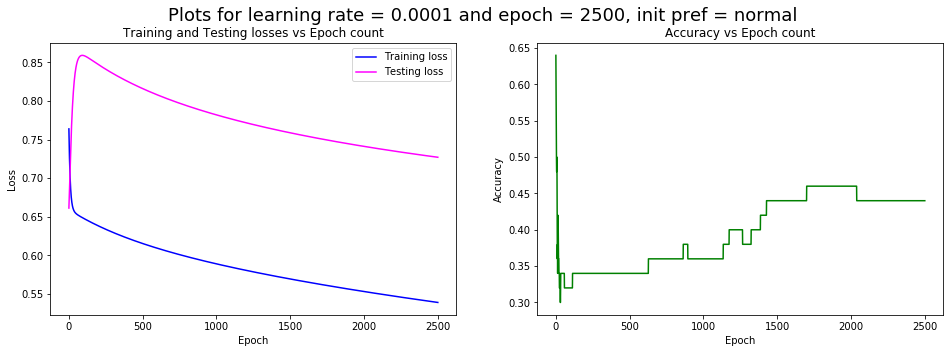

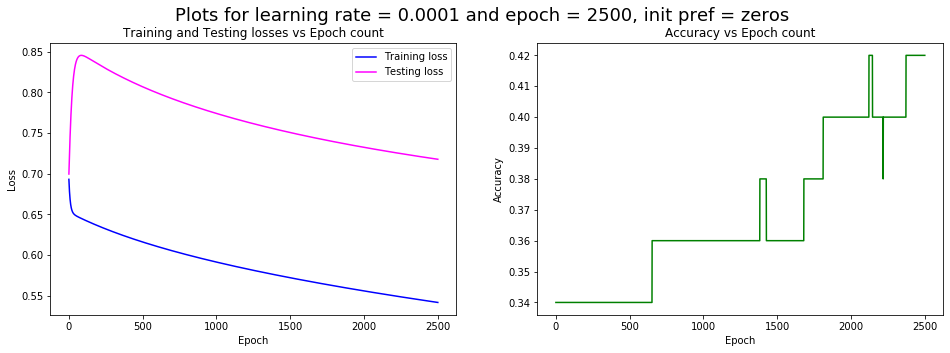

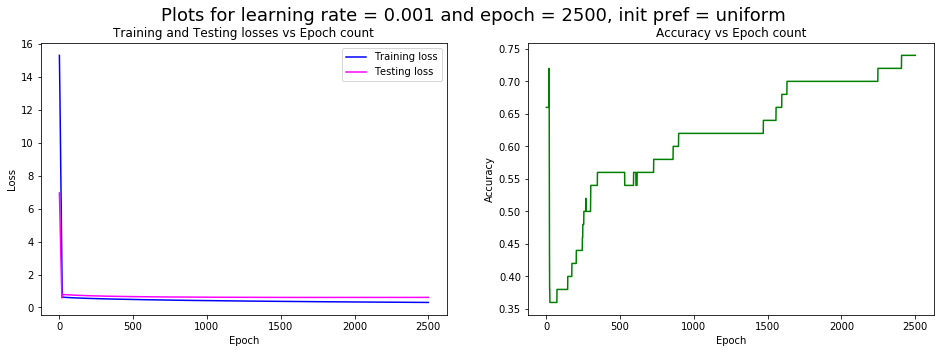

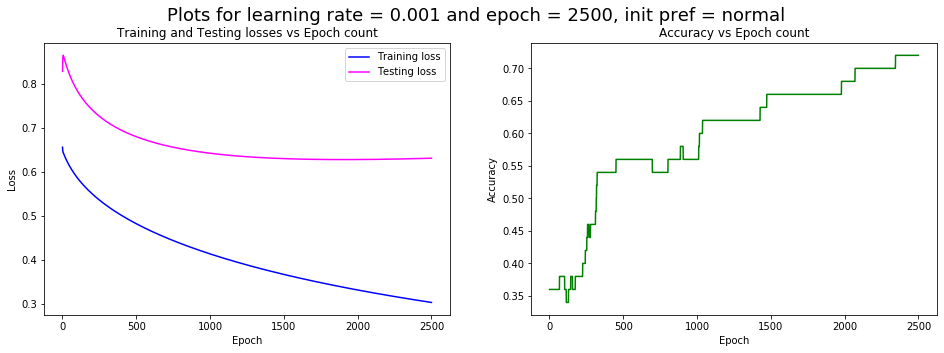

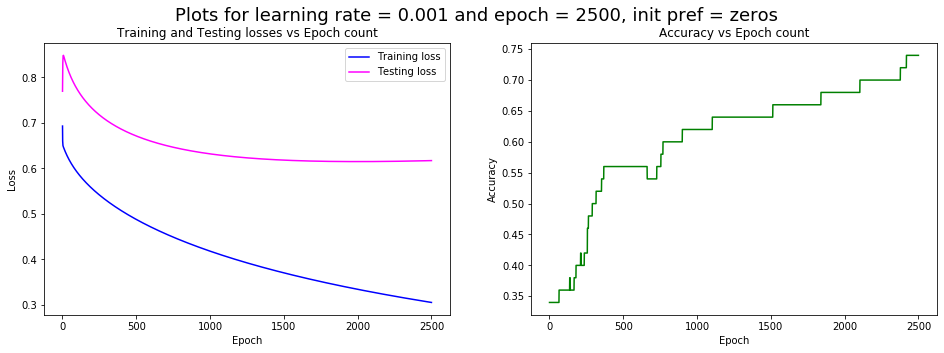

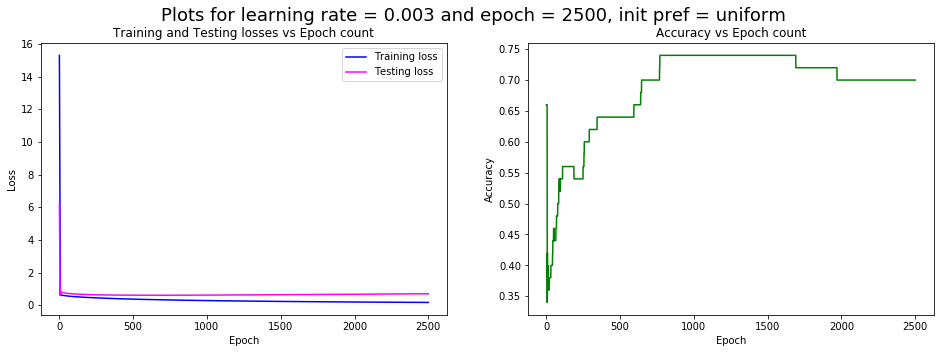

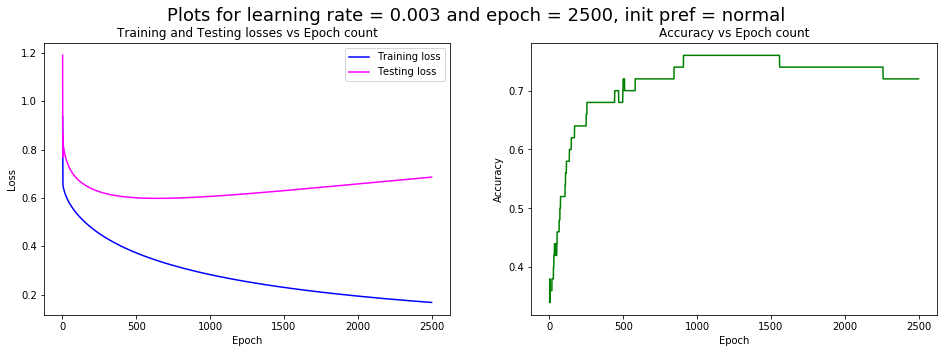

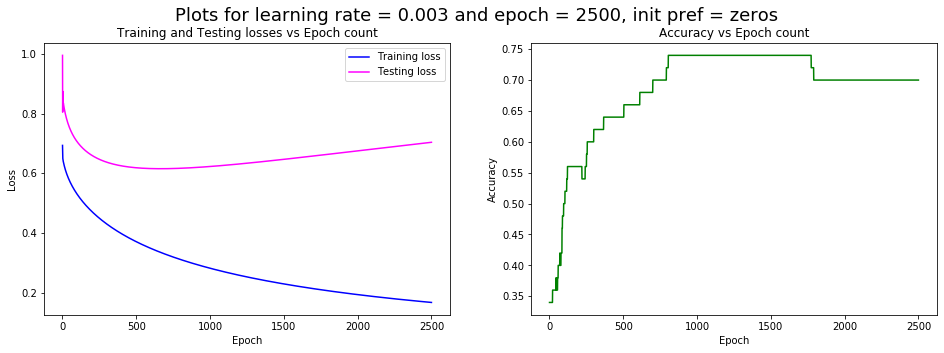

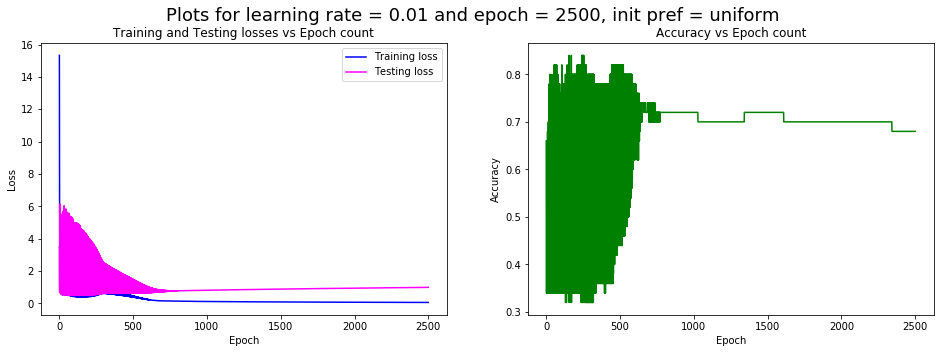

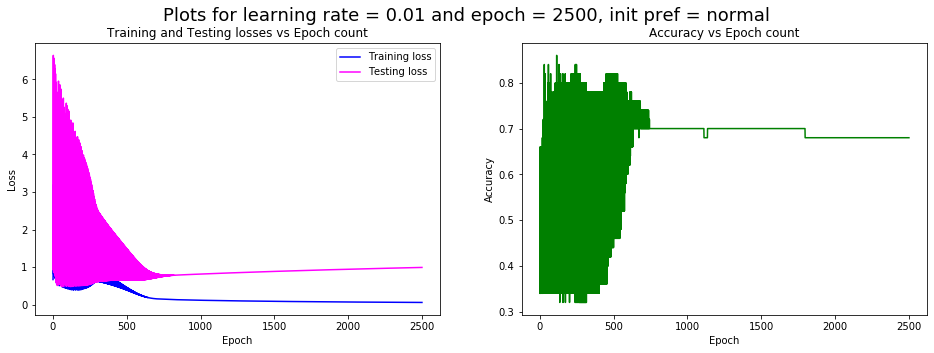

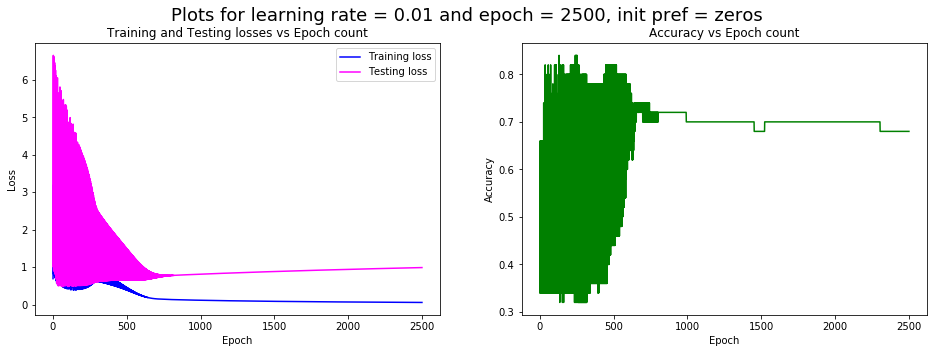

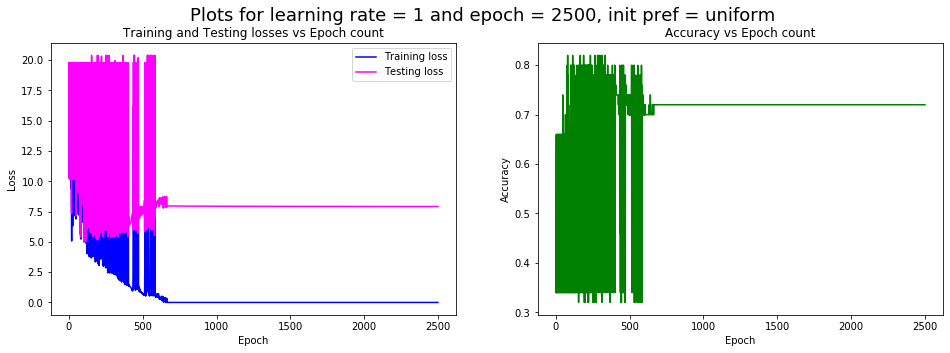

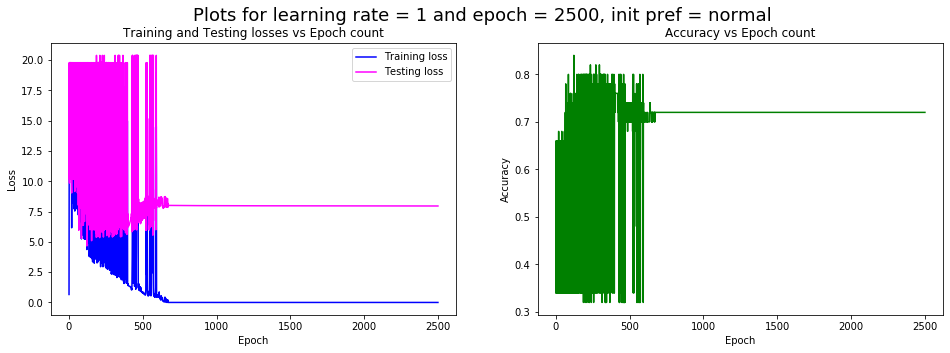

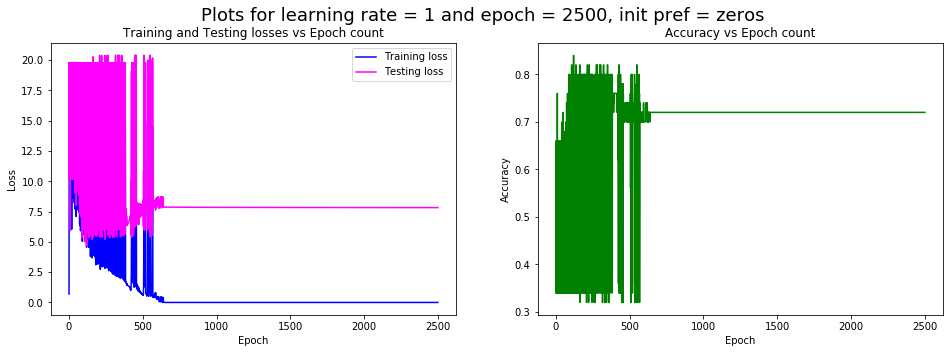

In [7]:
main_part2()

## Part 3
### Deep Learning with Keras
In this part, totally independent from the code written for Part 1 and Part 2. For this part the python script given in the url: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py will be used as basis and will be modified accordingly. As in the assignment it is stated that Keras will be used, the application uses tensorflow 1.0. 

In [8]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import os
import datetime

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

#### Hyperparameters for training
For the training process, the hyperparamaters used for training the model are the **batch size**, **number of classes in the dataset** and **number of epochs** that the model will be trained. These parameters will be given to the model instance in the following steps which is the main reason why it is defined externally.

In [9]:
## Training Parameters
batch_size = 128
num_classes = 2
epochs = 30

#### Formatting the data
According to the specifications of the dataset, the following adjustments have been done to the model. The image instances in the model are given as 64x64 RGB images. According to this, the images are reshaped accordingly and model instance is tuned for inputs having 3 color channels.

In [10]:
# input image dimensions
img_rows, img_cols = 64,64

# Intializing dataset
dataset = Dataset(train_dataset_path, test_dataset_path)

# the data, split between train and test sets
(x_train, y_train) = (dataset.get_training_data()['samples'], dataset.get_training_data()['labels'])
(x_test, y_test) = (dataset.get_testing_data()['samples'], dataset.get_testing_data()['labels'])

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (209, 64, 64, 3)
209 train samples
50 test samples


In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#### Model definition
Based in the given model in the specified url at the beginning of this part, the model properties are modified based on the hyperparameter definitions. The model is given in the above cell. For the assignment, a visual representation of the model is prepared. The prepared image is as follows: <img src="https://i.ibb.co/xSCgKhv/Screen-Shot-2020-03-23-at-22-04-10.png" alt="Screen-Shot-2020-03-23-at-22-04-10" border="0">

In [13]:
K.clear_session()
def generate_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model
## Model definition
model = generate_model()

Instructions for updating:
Colocations handled automatically by placer.


#### Training the model
Here the model is trained for 12 epochs. The result of the training process is provided as the output of the cell

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr = 0.001),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs= 12,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.summary()

Instructions for updating:
Use tf.cast instead.
Train on 209 samples, validate on 50 samples
Epoch 1/12
209/209 [==============================] - 2s 8ms/step - loss: 0.6904 - accuracy: 0.5024 - val_loss: 0.7422 - val_accuracy: 0.3600
Epoch 2/12
209/209 [==============================] - 1s 7ms/step - loss: 0.6636 - accuracy: 0.6029 - val_loss: 0.7700 - val_accuracy: 0.3400
Epoch 3/12
209/209 [==============================] - 1s 7ms/step - loss: 0.6661 - accuracy: 0.6220 - val_loss: 0.7859 - val_accuracy: 0.3400
Epoch 4/12
209/209 [==============================] - 1s 7ms/step - loss: 0.6671 - accuracy: 0.6555 - val_loss: 0.8101 - val_accuracy: 0.3400
Epoch 5/12
209/209 [==============================] - 1s 7ms/step - loss: 0.6482 - accuracy: 0.6555 - val_loss: 0.8224 - val_accuracy: 0.3400
Epoch 6/12
209/209 [==============================] - 1s 7ms/step - loss: 0.6554 - accuracy: 0.6507 - val_loss: 0.8152 - val_accuracy: 0.3400
Epoch 7/12
209/209 [==============================] - 1

#### Initializing the log directory and the callback function for SGD model
To prevent mixing the log files the log regarding the runs, each of the models will have its own directory. 

In [15]:
K.clear_session()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callback = keras.callbacks.tensorboard_v1.TensorBoard(log_dir='./logs/SGD', 
                histogram_freq=1, batch_size=32, 
                write_graph=True, write_grads=False, 
                write_images=True, embeddings_freq=0, 
                embeddings_layer_names=None, embeddings_metadata=None, 
                embeddings_data=None, update_freq='epoch')

#### Training the model
The model is being compiled with the following two cells, where the model in the first cell uses Stochastic Gradient Descent as the loss function and the second one uses AdaDelta approach. The results are shown using TensorBoard. The training process is done for 30 epochs

In [16]:
model = generate_model()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr = 0.001),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks = [callback])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.summary()

Train on 209 samples, validate on 50 samples
Epoch 1/30
209/209 [==============================] - 2s 8ms/step - loss: 0.7080 - accuracy: 0.4928 - val_loss: 0.7504 - val_accuracy: 0.3400
Epoch 2/30
209/209 [==============================] - 1s 7ms/step - loss: 0.6680 - accuracy: 0.6316 - val_loss: 0.7901 - val_accuracy: 0.3400
Epoch 3/30
209/209 [==============================] - 1s 7ms/step - loss: 0.6728 - accuracy: 0.6220 - val_loss: 0.8178 - val_accuracy: 0.3400
Epoch 4/30
209/209 [==============================] - 1s 7ms/step - loss: 0.6495 - accuracy: 0.6220 - val_loss: 0.8221 - val_accuracy: 0.3400
Epoch 5/30
209/209 [==============================] - 1s 7ms/step - loss: 0.6400 - accuracy: 0.6459 - val_loss: 0.8408 - val_accuracy: 0.3400
Epoch 6/30
209/209 [==============================] - 1s 7ms/step - loss: 0.6341 - accuracy: 0.6651 - val_loss: 0.8524 - val_accuracy: 0.3400
Epoch 7/30
209/209 [==============================] - 1s 7ms/step - loss: 0.6490 - accuracy: 0.6699 - v

In [17]:
%load_ext tensorboard.notebook
%tensorboard --logdir=./logs/SGD

In [18]:
K.clear_session()
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
ada_callback = keras.callbacks.tensorboard_v1.TensorBoard(log_dir='./logs/Adadelta', 
                histogram_freq=1, batch_size=32, 
                write_graph=True, write_grads=False, 
                write_images=True, embeddings_freq=0, 
                embeddings_layer_names=None, embeddings_metadata=None, 
                embeddings_data=None, update_freq='epoch')

In [19]:
## Model definition
model1 = generate_model()

In [20]:
model1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(x_train.shape)

model1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test), callbacks = [ada_callback])
score = model1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model1.summary()

(209, 64, 64, 3)
Train on 209 samples, validate on 50 samples
Epoch 1/30
209/209 [==============================] - 2s 9ms/step - loss: 2.0162 - accuracy: 0.5502 - val_loss: 0.6436 - val_accuracy: 0.6600
Epoch 2/30
209/209 [==============================] - 2s 8ms/step - loss: 0.8444 - accuracy: 0.4785 - val_loss: 0.9580 - val_accuracy: 0.3400
Epoch 3/30
209/209 [==============================] - 2s 7ms/step - loss: 0.6628 - accuracy: 0.6316 - val_loss: 0.7204 - val_accuracy: 0.3400
Epoch 4/30
209/209 [==============================] - 2s 7ms/step - loss: 0.6634 - accuracy: 0.6603 - val_loss: 0.7634 - val_accuracy: 0.3400
Epoch 5/30
209/209 [==============================] - 2s 7ms/step - loss: 0.6421 - accuracy: 0.6555 - val_loss: 0.7239 - val_accuracy: 0.3400
Epoch 6/30
209/209 [==============================] - 2s 8ms/step - loss: 0.6222 - accuracy: 0.6555 - val_loss: 0.7244 - val_accuracy: 0.3400
Epoch 7/30
209/209 [==============================] - 2s 7ms/step - loss: 0.6252 - acc

In [21]:
%load_ext tensorboard.notebook
%tensorboard --logdir=./logs/Adadelta

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [28]:
learning_rates = [1, 0.1, 0.01, 0.001, 0.0001]
for rate in learning_rates:
    K.clear_session()
    model = generate_model()
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    sgd_callback = keras.callbacks.tensorboard_v1.TensorBoard(log_dir=('./logs/SGD_50/' + str(rate)), 
                histogram_freq=1, batch_size=32, 
                write_graph=True, write_grads=False, 
                write_images=True, embeddings_freq=0, 
                embeddings_layer_names=None, embeddings_metadata=None, 
                embeddings_data=None, update_freq='epoch')
    
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr = rate),
              metrics=['accuracy'])

    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50,
          verbose=0,
          validation_data=(x_test, y_test), callbacks = [sgd_callback])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Learning rate: ', rate)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Learning rate:  1
Test loss: 10.637942962646484
Test accuracy: 0.3400000035762787
Learning rate:  0.1
Test loss: 1.4142394971847534
Test accuracy: 0.3400000035762787
Learning rate:  0.01
Test loss: 0.8993176603317261
Test accuracy: 0.3400000035762787
Learning rate:  0.001
Test loss: 0.8335954189300537
Test accuracy: 0.3400000035762787
Learning rate:  0.0001
Test loss: 0.7922136044502258
Test accuracy: 0.3400000035762787


In [31]:
%load_ext tensorboard.notebook
%tensorboard --logdir=./logs/SGD_50/1

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [35]:
%load_ext tensorboard.notebook
%tensorboard --logdir=./logs/SGD_50/0.1

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [37]:
%load_ext tensorboard.notebook
%tensorboard --logdir=./logs/SGD_50/0.01

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [40]:
%load_ext tensorboard.notebook
%tensorboard --logdir=./logs/SGD_50/0.001

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook


In [43]:
%load_ext tensorboard.notebook
%tensorboard --logdir=./logs/SGD_50/0.0001

The tensorboard.notebook extension is already loaded. To reload it, use:
  %reload_ext tensorboard.notebook
